<a href="https://colab.research.google.com/github/LeconteEsteban/Sae_3A/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

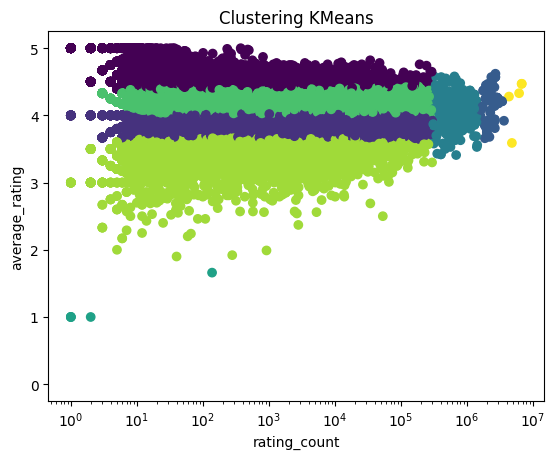

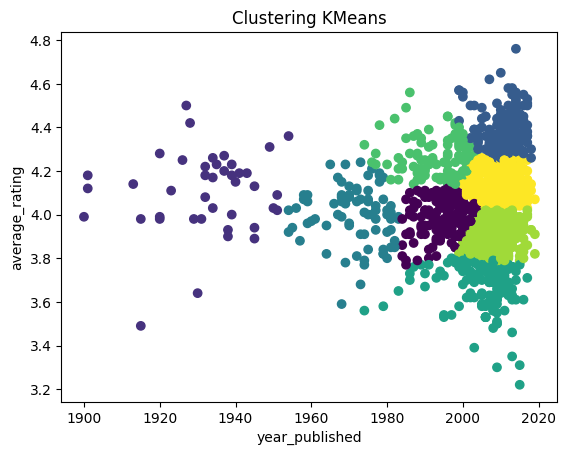

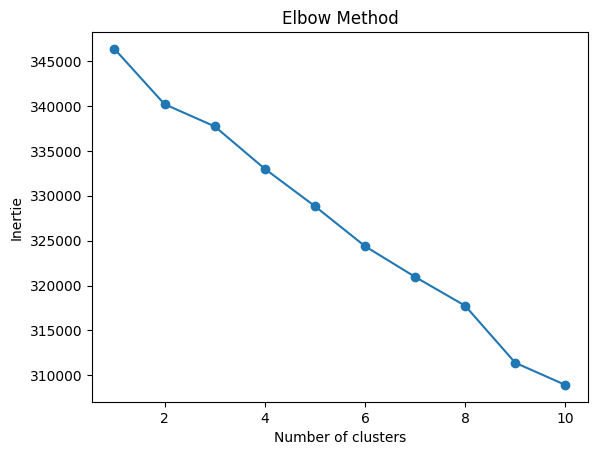

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


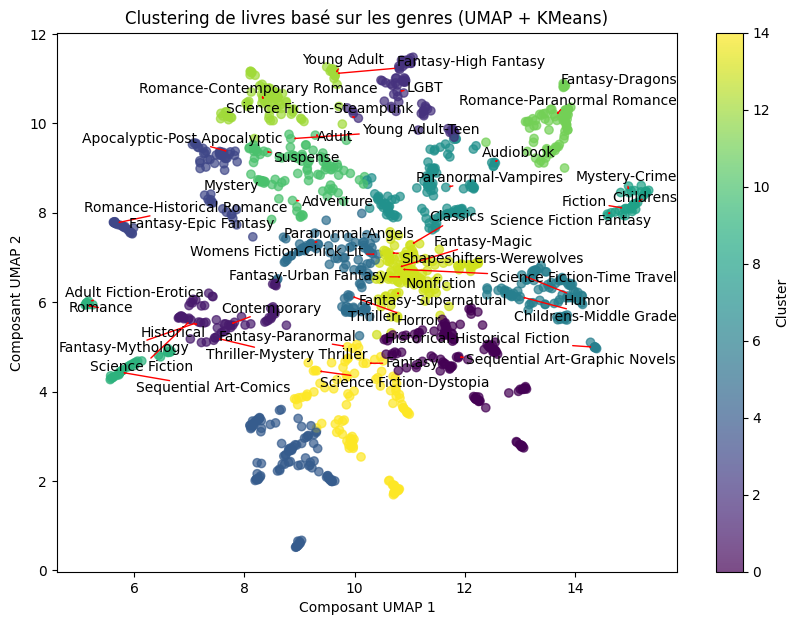

In [3]:
#Created by Buckel Angely
!pip install adjustText
!pip install umap-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans
import requests
from io import StringIO
import re
import umap
from collections import Counter

######## Import the Data
# URL of Google Sheets about books
url = 'https://docs.google.com/spreadsheets/d/1cWkVcuw_wTQxqTgJcRfCZTweSb06tzfHVbuAd73owNw/export?format=csv&gid=1613894920'

# download the CSV file
response = requests.get(url)

# Check if it succed
if response.status_code == 200:
     # Convert the content to a string and use StringIO to handle it as a file-like object
    csv_data = StringIO(response.content.decode('utf-8'))

    # Read the CSV into a DataFrame with low_memory=False to avoid mixed dtype warnings and range for the number of columns to import
    df = pd.read_csv(csv_data, low_memory=False)
    df = df[df.columns[:25]]
else:
    print(f"ERROR WHILE DOWNLOADING THE FILE: {response.status_code}")

###### Cluster average_rating by rating_count
# Sélectionner les colonnes pertinentes pour le clustering
features = df[['rating_count','average_rating']]

# Standardiser les données
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Appliquer l'algorithme de clustering KMeans
kmeans = KMeans(n_clusters=8, random_state=42)  # Vous pouvez ajuster le nombre de clusters
df['cluster'] = kmeans.fit_predict(features_scaled)

# Visualiser les clusters (si les données sont en 2D)
if features.shape[1] == 2:
    plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=df['cluster'], cmap='viridis')
    plt.xscale('log')
    plt.xlabel(features.columns[0])
    plt.ylabel(features.columns[1])
    plt.title('Clustering KMeans')
    plt.show()

####### Cluster average-rating by years
df_clust = df.dropna()

# Retirer les lignes où 'year_published' est inférieur à 1500
df_clust = df_clust[df_clust['year_published'] >= 1900]

# Sélectionner les colonnes pertinentes pour le clustering
features = df_clust[['year_published','average_rating']]

# Standardiser les données
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Appliquer l'algorithme de clustering KMeans
kmeans = KMeans(n_clusters=8, random_state=42)  # Vous pouvez ajuster le nombre de clusters
df_clust['cluster'] = kmeans.fit_predict(features_scaled)

# Visualiser les clusters (si les données sont en 2D)
if features.shape[1] == 2:
    plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=df_clust['cluster'], cmap='viridis')
    #plt.xscale('log')
    plt.xlabel(features.columns[0])
    plt.ylabel(features.columns[1])
    plt.title('Clustering KMeans')
    plt.show()

######## Cluster of genre
df_clust = df.dropna()
df_genre = df_clust[['genre_and_votes']].copy()

# Fonction pour transformer la colonne 'genre_and_votes' en un dictionnaire {genre: votes}
def parse_genre_votes(genre_and_votes):
    genre_votes = re.findall(r'([\w\s-]+)\s(\d+)', genre_and_votes)
    return {genre.strip(): int(vote) for genre, vote in genre_votes}

# Appliquer la fonction à la colonne 'genre_and_votes' pour obtenir une liste de dictionnaires
df_genre['genre_votes_dict'] = df_genre['genre_and_votes'].apply(parse_genre_votes)

# Obtenir la liste de tous les genres uniques
all_genres = set()
df_genre['genre_votes_dict'].apply(lambda x: all_genres.update(x.keys()))

# Créer un dictionnaire pour stocker les données des nouvelles colonnes
genre_data = {}
for genre in all_genres:
    genre_data[genre] = df_genre['genre_votes_dict'].apply(lambda x: x.get(genre, 0))

# Concaténer les nouvelles colonnes au DataFrame df_genre
df_genre = pd.concat([df_genre, pd.DataFrame(genre_data)], axis=1)

# Supprimer la colonne intermédiaire
df_genre = df_genre.drop(columns=['genre_votes_dict'])

# Sélectionner les colonnes de genres pour le clustering
genre_columns = list(all_genres)
genre_features = df_genre[genre_columns]

# Standardiser les données
scaler = StandardScaler()
genre_features_scaled = scaler.fit_transform(genre_features)

# Appliquer l'algorithme de clustering KMeans
kmeans = KMeans(n_clusters=30, random_state=42, n_init=10)
df_genre['cluster'] = kmeans.fit_predict(genre_features_scaled)

#Pour déterrminer le nombre de cluster
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=42, n_init=10)
    km.fit(genre_features_scaled)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertie')
plt.title('Elbow Method')
plt.show()

# Créer un tableau de comptage des genres
genre_counts = df_genre[genre_columns].sum().reset_index()
genre_counts.columns = ['genre', 'count']

# Créer un tableau de comptage des genres
genre_counts = df_genre[genre_columns].sum().reset_index()
genre_counts.columns = ['genre', 'count']
genre_counts = genre_counts[genre_counts['count'] > 0] # add this line to filter out counts that are zero

excluded_genre = ''

# Définir un seuil pour les genres principaux
threshold = 10000
main_genres = [genre for genre, count in genre_counts.set_index('genre')['count'].items() if count >= threshold and genre != excluded_genre] # change this line to use the numeric count column

# Standardiser les données avant le clustering
scaler = StandardScaler()
genre_features_scaled = scaler.fit_transform(genre_features)

# Appliquer UMAP pour réduire les dimensions à 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_umap = umap_model.fit_transform(genre_features_scaled)

# Appliquer KMeans aux données UMAP réduites
kmeans_umap = KMeans(n_clusters=15, random_state=42, n_init=10)
df_genre['cluster_umap'] = kmeans_umap.fit_predict(reduced_umap)

# Visualiser les clusters avec UMAP
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], c=df_genre['cluster_umap'], cmap='viridis', alpha=0.7)
plt.xlabel('Composant UMAP 1')
plt.ylabel('Composant UMAP 2')
plt.title('Clustering de livres basé sur les genres (UMAP + KMeans)')
plt.colorbar(label='Cluster')

from adjustText import adjust_text

# Création d'une liste pour stocker les annotations
texts = []

# Boucle pour ajouter les étiquettes uniquement pour les genres principaux
for i, genre in enumerate(genre_columns):
    if genre in main_genres:
        # Si le genre en question est celui qui pose problème
        if genre == "Apocalyptic-Post Apocalyptic":
            # Ajouter l'annotation avec un décalage manuel
            texts.append(
                plt.annotate(
                    genre,
                    (reduced_umap[i, 0] + 0.01, reduced_umap[i, 1] + 0.05),  # Ajuster ici le décalage
                    fontsize=10,
                    ha='center',
                    va='center'
                )
            )
        else:
            # Ajouter les autres annotations normalement
            texts.append(
                plt.annotate(
                    genre,
                    (reduced_umap[i, 0], reduced_umap[i, 1]),
                    fontsize=10,
                    ha='center',
                    va='center'
                )
            )

# Ajustement des textes pour éviter les superpositions
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.show()